In [1]:
from Framingham_utils import *
from Steno_utils import *
from Inger_utils import *
from exploratory_data_analysys import * 
from sklearn.impute import KNNImputer

from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from train_utils import *

from model_evaluation import *

from constants import * 

import copy 

from imblearn.over_sampling import ADASYN

import warnings 

# Filter warnings 
warnings.filterwarnings("ignore")

# Path to store obtained reusults
STORE_PATH = r".\DSD2023_results"

# Save current working directory to come back later 
wd = os.getcwd()

fram_data, fram_X, fram_Y, fram_feat_names, fram_y_tag = prepare_Framingham(dataset_path = FRAM_PATH, filename = fram_filename)
steno_data, steno_X, steno_Y, steno_feat_names, steno_y_tag = prepare_Steno(dataset_path = STENO_PATH, filename1 = steno_filename1, filename2 = steno_filename2)
inger_data, inger_X, inger_Y, inger_feat_names, inger_y_tag = prepare_Inger(dataset_path = INGER_PATH, filename = inger_filename)

# Go back to previous directory 
os.chdir(wd)

# Data partition - Train (80%) + Validation (20%)
fram_X_train, fram_X_val, fram_y_train, fram_y_val, fram_train_data, fram_validation_data = train_test_split_and_concat(fram_X, fram_Y, test_size=0.2, random_state=4)
steno_X_train, steno_X_val, steno_y_train, steno_y_val, steno_train_data, steno_validation_data = train_test_split_and_concat(steno_X, steno_Y, test_size=0.2, random_state=4)

In [2]:
# Select the common features in Frammingham and Steno 
fram_2common_X_train = fram_X_train[['male','age','currentSmoker','prevalentStroke','sysBP']]
fram_2common_X_val = fram_X_val[['male','age','currentSmoker','prevalentStroke','sysBP']]

steno_2common_X_train = steno_X_train[['sex','age','smoking','prevcvd','sbp']]
steno_2common_X_val = steno_X_val[['sex','age','smoking','prevcvd','sbp']] 

In [3]:
# KNN-Imputation (training and validation set separately)
# Only for Framingham and Inger datasets 
# Imputer declaration 
imputer = KNNImputer(missing_values = np.nan , n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean',
                      copy = 'false') 

# Imputation (training and validation separately)
fram_train_data = imputer.fit_transform(fram_train_data)
fram_validation_data = imputer.fit_transform(fram_validation_data) 

# Conversion from np.array to pd.DataFrame and convert from float to original datatype
fram_train_data, fram_X_train, fram_y_train = numerical_conversion_Framingham(fram_train_data, fram_feat_names, fram_y_tag)
fram_validation_data, fram_X_val, fram_y_val = numerical_conversion_Framingham(fram_validation_data, fram_feat_names, fram_y_tag)

In [4]:
# Balance dataset (only Frammingham)
# Balancing with ADASYN
fram_X_train, fram_y_train = ADASYN(sampling_strategy = 'minority',
                                                random_state = 5,
                                                n_neighbors = 5,
                                                n_jobs = None).fit_resample(fram_X_train, fram_y_train) 

# Add column Y to dataframe 
fram_X_train.reset_index(drop=True, inplace=True)
fram_y_train.reset_index(drop=True, inplace=True)
fram_train_data = pd.concat([fram_X_train, fram_y_train], axis = 1)

In [5]:
# Convert steno y from series to dataframe 
steno_y_train = pd.DataFrame(steno_y_train)
steno_y_train.columns = [steno_y_tag]

steno_y_val = pd.DataFrame(steno_y_val)
steno_y_val.columns = [steno_y_tag]

In [6]:
# Extract common features to train ML models with 3 data subsets with just the common features
fram_all_common_X_train = fram_X_train[['age', 'male','currentSmoker']]
fram_all_common_X_val = fram_X_val[['age', 'male','currentSmoker']]

steno_all_common_X_train = steno_X_train[['age', 'sex','smoking']]
steno_all_common_X_val = steno_X_val[['age', 'sex','smoking']]

# Make a substudy with Steno and Framingham databases since they are more similar
fram_2common_X_train = fram_X_train[['male','age','currentSmoker','prevalentStroke','sysBP']]
fram_2common_X_val = fram_X_val[['male','age','currentSmoker','prevalentStroke','sysBP']]

steno_2common_X_train = steno_X_train[['sex','age','smoking','prevcvd','sbp']]
steno_2common_X_val = steno_X_val[['sex','age','smoking','prevcvd','sbp']] 

In [7]:
# To rename variables names and format to be the same, so dataset can be used to train the other model
fram_2common_X_train.rename(columns={'male':'sex', 'currentSmoker':'smoking','prevalentStroke':'prevcvd','sysBP':'sbp'}, inplace = True)
fram_2common_X_val.rename(columns={'male':'sex', 'currentSmoker':'smoking','prevalentStroke':'prevcvd','sysBP':'sbp'}, inplace = True)

# sex = 1 is male, sex = 0 is female, so no transformation is needed

In [8]:
# Go to "distributions" directory, if not create one 
if not os.path.exists('EDA'):
    os.makedirs('EDA')

# Change directory to "distributions"
os.chdir('EDA')

In [9]:
# Go to "compared_distributions" directory, if not create one
if not os.path.exists('compared_distributions'):
    os.makedirs('compared_distributions')

# Change directory to "compared_distributions"
os.chdir('compared_distributions')

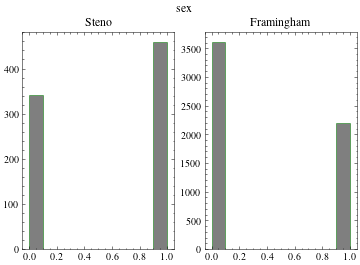

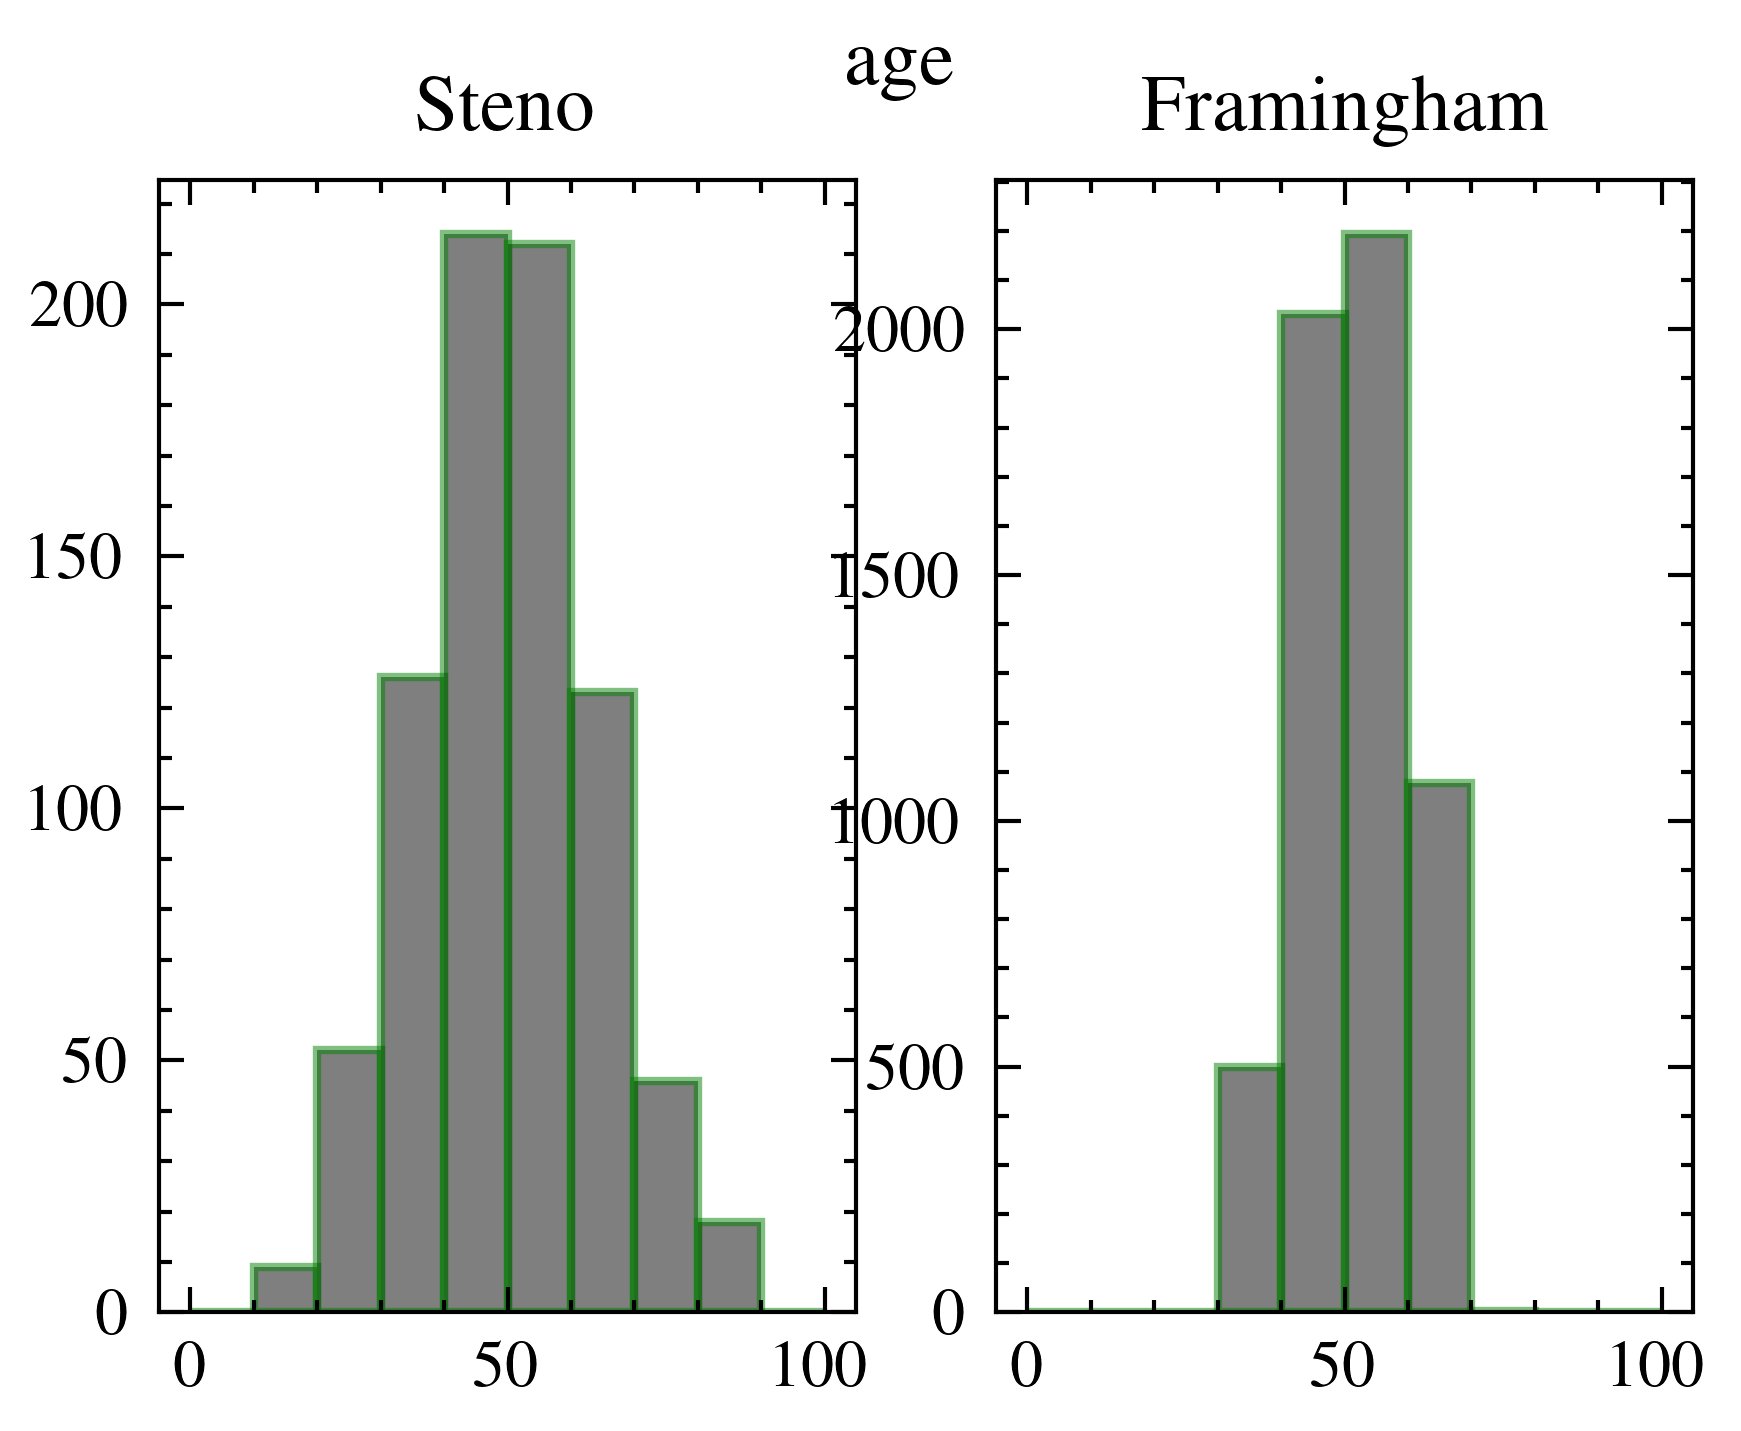

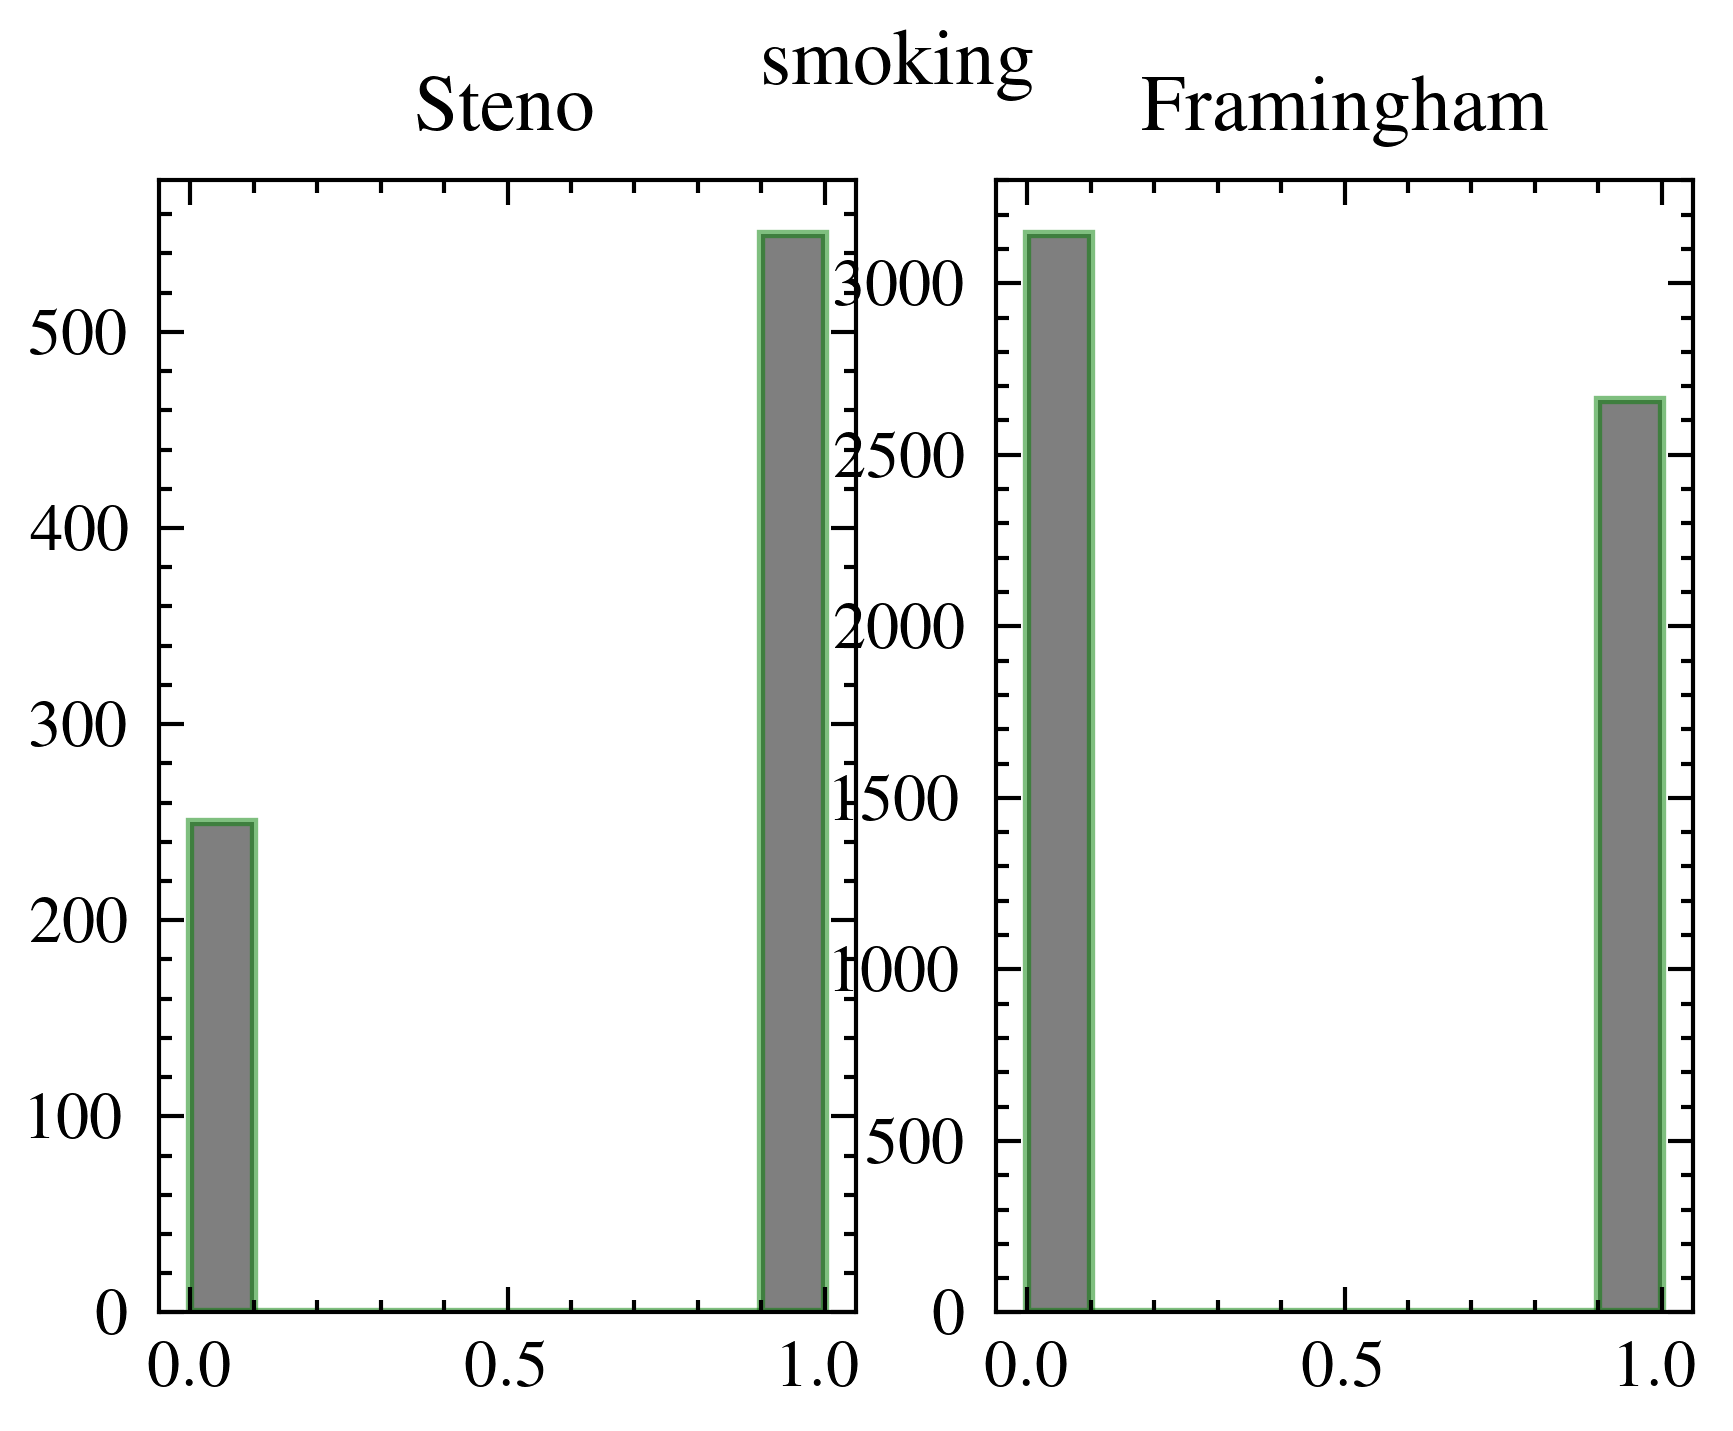

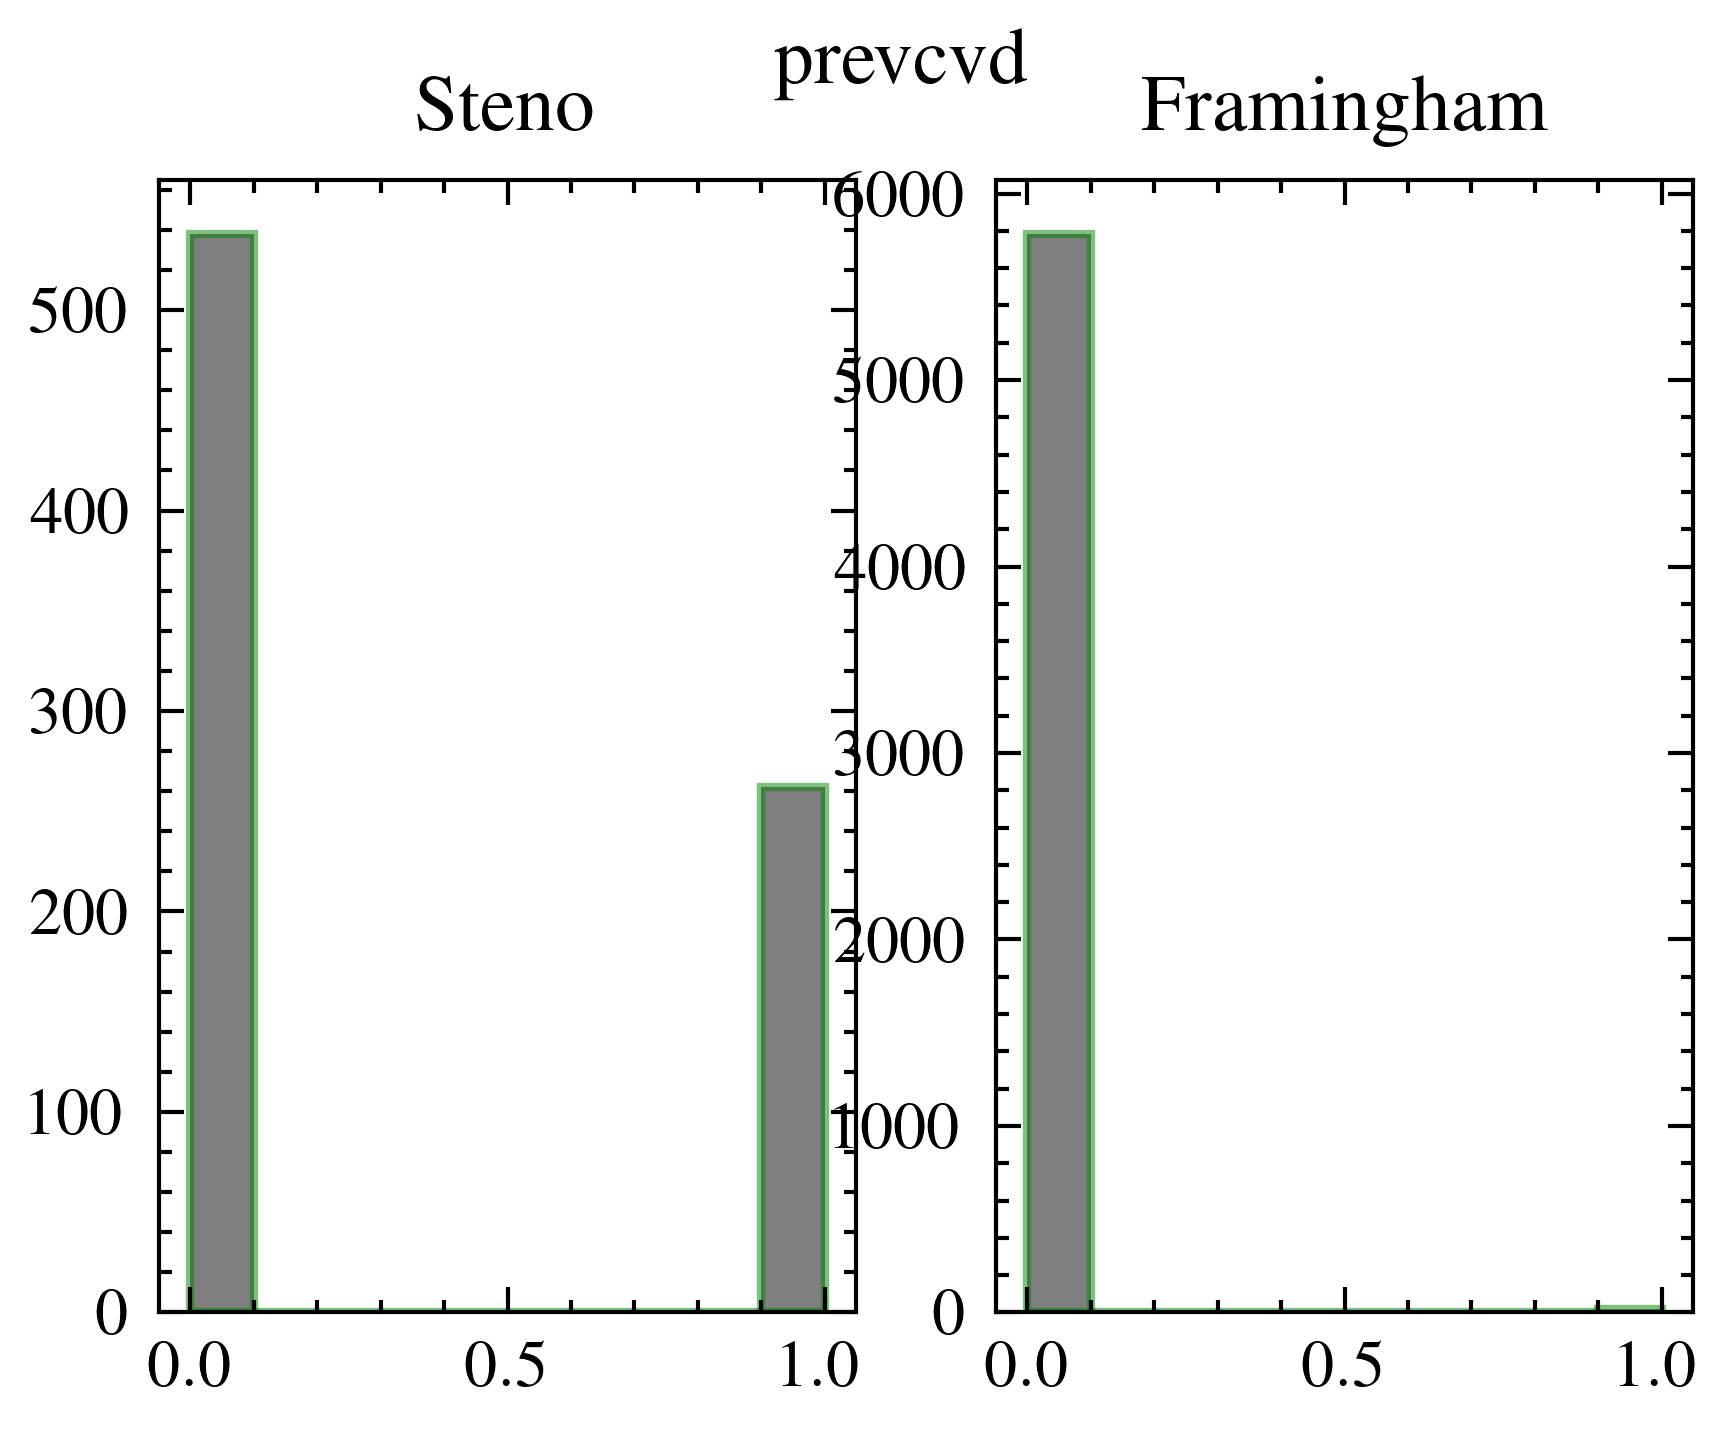

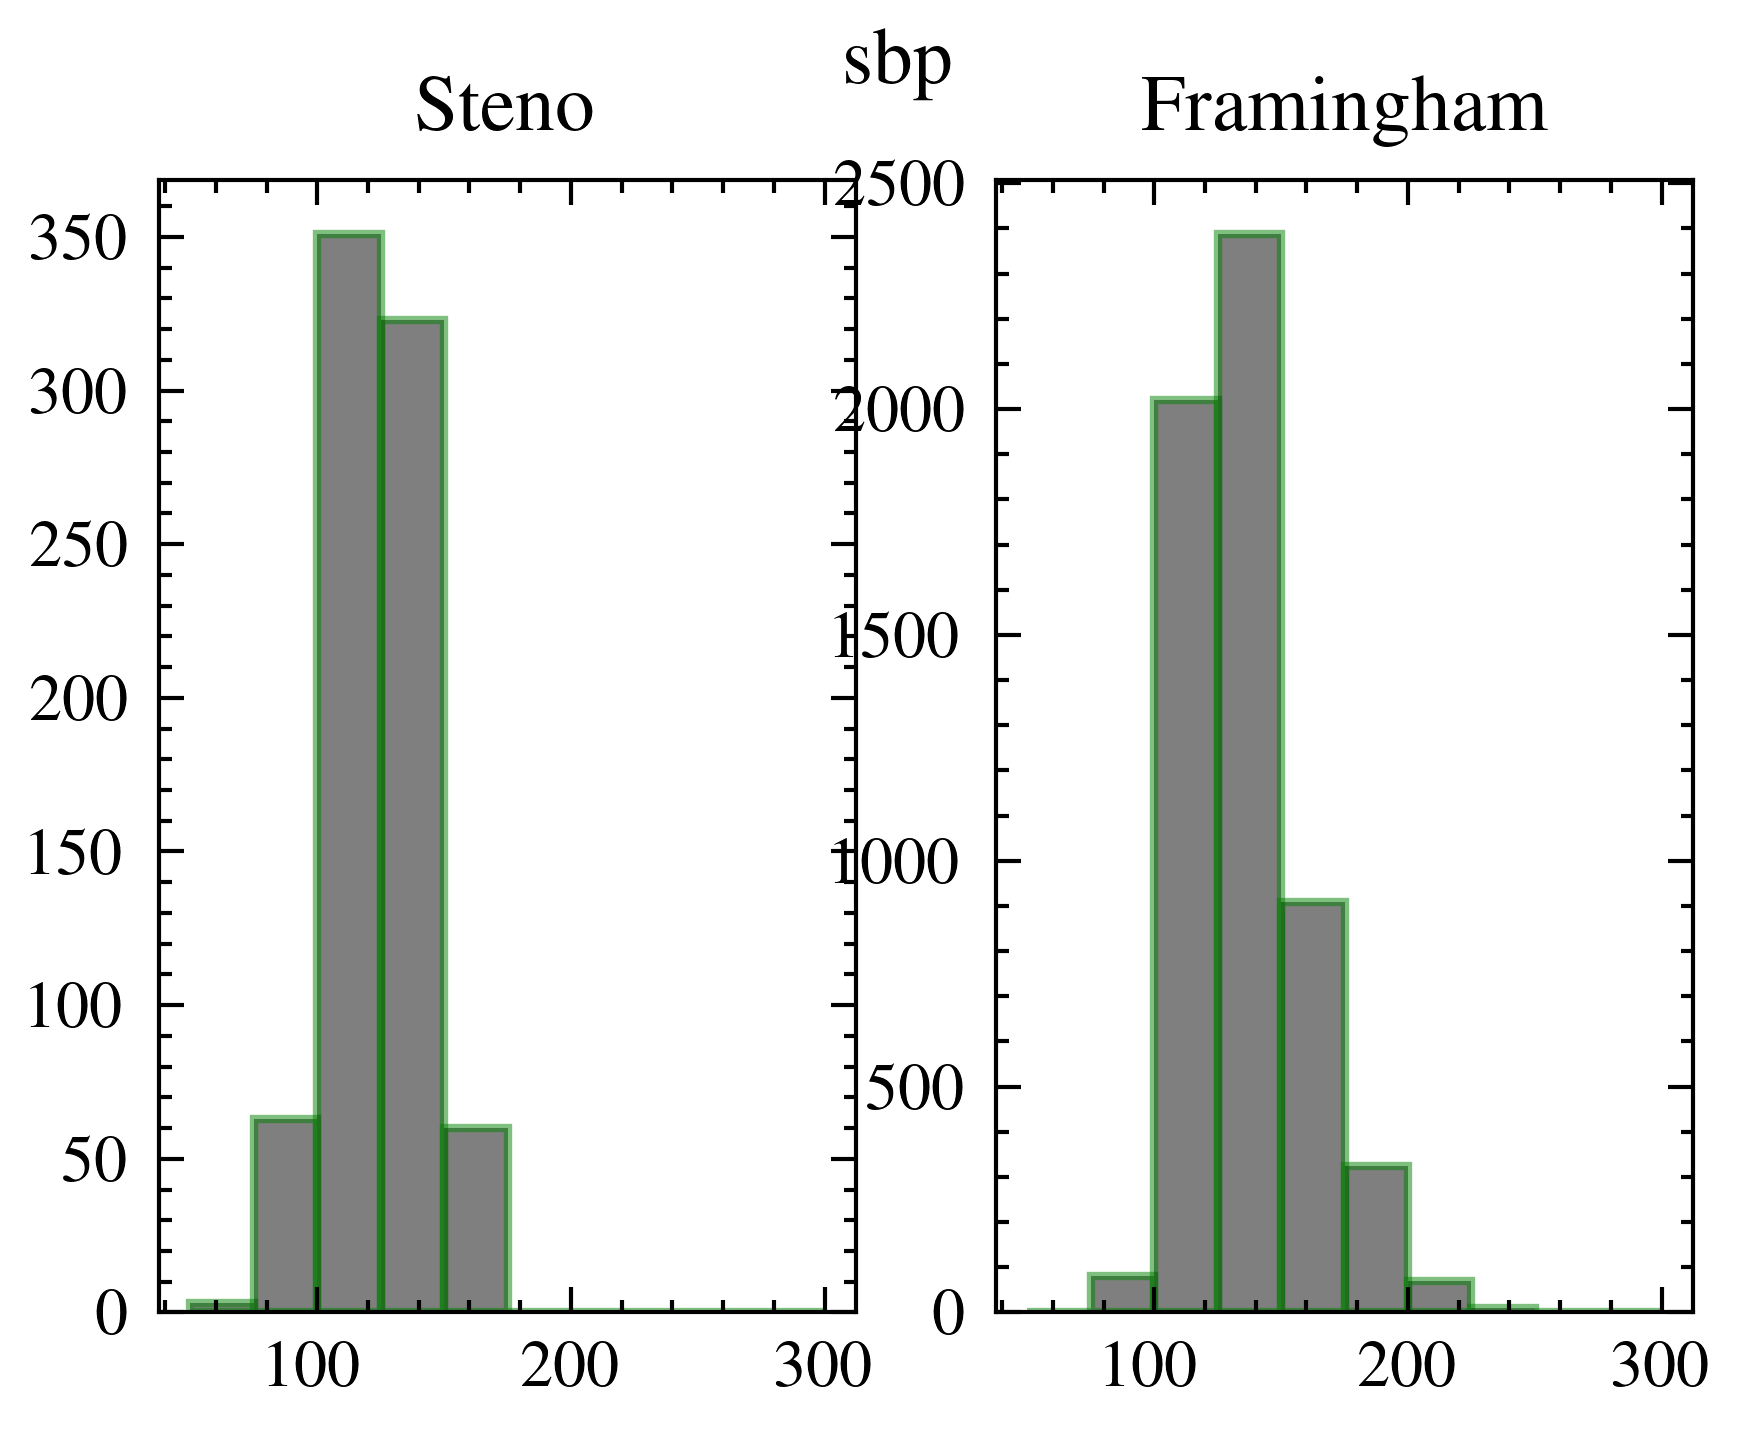

In [10]:
# Distribution comparison of Steno and Frammingham datasets in the common features 

# Dummy counter 
i = -1

# List of ranges to plot the histograms
ranges = [(0,1),(0,100),(0,1),(0,1),(50,300)]

for feat in steno_2common_X_train:
    
    i = i + 1

    # Set IEEE style
    plt.style.use(['science','ieee'])

    # Figure
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    # Set figure title
    fig.suptitle(feat)

    ax[0].hist(steno_2common_X_train[feat], range = ranges[i], alpha=0.5, ec='g', label="", fill=True)
    ax[0].set_title('Steno')
    ax[1].hist(fram_2common_X_train[feat], range = ranges[i],  alpha=0.5, ec='g', label="", fill=True)
    ax[1].set_title('Framingham')

    # Save figure with high resolution 
    fig.savefig(feat + '_compared.png', dpi=300, bbox_inches='tight')

In [11]:
# # Perform test Shapiro-Wilk to check normality of the distributions
# # Dummy counter

# from scipy import stats

# shapiro_test_fram_age = stats.shapiro(fram_2common_X_train['age'])
# shapiro_test_fram_bp = stats.shapiro(fram_2common_X_train['sysBP'])

# # Print statistics and p-value
# print('Shapiro-Wilk test for Frammingham age: ', shapiro_test_fram_age)
# print('Shapiro-Wilk test for Frammingham blood pressure: ', shapiro_test_fram_bp)

# shapiro_test_steno_age = stats.shapiro(steno_2common_X_train['age'])
# shapiro_test_steno_bp = stats.shapiro(steno_2common_X_train['sbp'])

# # Print statistics and p-value
# print('Shapiro-Wilk test for Steno age: ', shapiro_test_steno_age)
# print('Shapiro-Wilk test for Steno blood pressure: ', shapiro_test_steno_bp)

In [12]:
# Counts 0 and 1 in prevalentStroke 
# print('Frammingham gender counts (%): ', fram_2common_X_train['male'].value_counts()*100/len(fram_2common_X_train))
# print('Frammingham smoker counts (%): ', fram_2common_X_train['currentSmoker'].value_counts()*100/len(fram_2common_X_train))
# print('Frammingham prevalentStroke counts (%): ', fram_2common_X_train['prevalentStroke'].value_counts()*100/len(fram_2common_X_train))


# print('Steno gender counts (%): ', steno_2common_X_train['sex'].value_counts()*100/len(steno_2common_X_train))
# print('Steno smoker counts (%): ', steno_2common_X_train['smoking'].value_counts()*100/len(steno_2common_X_train))
# print('Steno prevalentStroke counts (%): ', steno_2common_X_train['prevcvd'].value_counts()*100/len(steno_2common_X_train))


In [13]:
os.chdir('..')

In [14]:
datasets = ('Frammingham 5 commons', 'Steno 5 commons')
classifiers = {'SVM' : {}, 'MLP' : {}}
regressors = {'SVM' : {}, 'MLP': {}}
class_metrics = {'f1' : np.zeros(1), 'roc' : np.zeros(1), 'auc' : np.zeros(1), 'prob':  np.zeros(1)}
reg_metrics = {'mae' : np.zeros(1), 'mse' : np.zeros(1), 'R1' : np.zeros(1)}

# Generate dict to store results 
metrics_dict =  get_eval_dictionaries(datasets, classifiers, regressors, class_metrics, reg_metrics)

In [15]:
# Declare common numerical features to leave binary variables as they are 
common_numerical_features = ['age', 'sbp']

# Cross standardization (i.e., Frammingham datasets will be normalized according to Steno's mean and std)
fram_2common_train_data, fram_2common_X_train, fram_2common_y_train = cross_standardization(steno_2common_X_train, fram_2common_X_train, fram_y_train, common_numerical_features)

# Validation 
steno_2common_validation_data, steno_2common_X_val, steno_2common_y_val = cross_standardization(steno_2common_X_train, steno_2common_X_val, steno_y_val, common_numerical_features)
fram_2common_validation_data, fram_2common_X_val, fram_2common_y_val = cross_standardization(steno_2common_X_train, fram_2common_X_val, fram_y_val, common_numerical_features)

# The reference is standardized the last, to properly standardize the rest 
steno_2common_train_data, steno_2common_X_train, steno_2common_y_train = standardization(steno_2common_X_train, steno_y_train, common_numerical_features)

In [16]:
# Go to "overlapped_distributions" directory, if not create one
if not os.path.exists('overlapped_distributions'):
    os.makedirs('overlapped_distributions')

# Change directory to "compared_distributions"
os.chdir('overlapped_distributions')

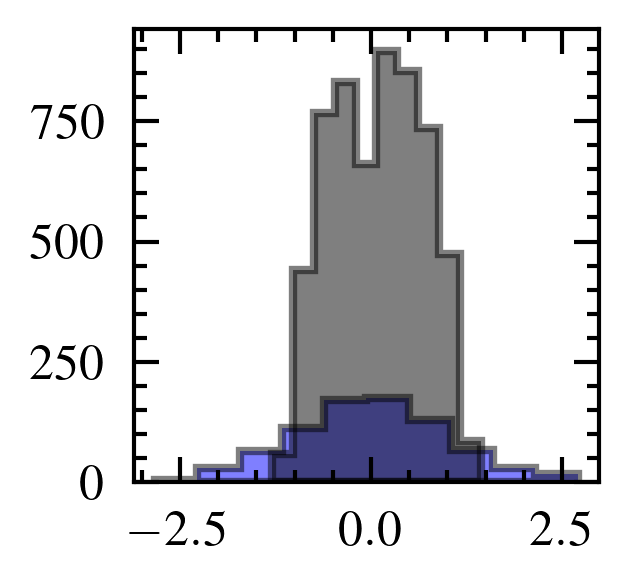

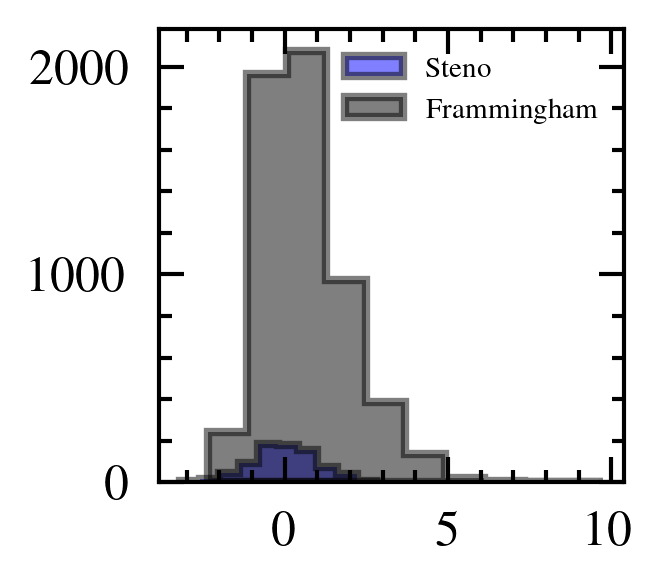

In [47]:
# Distribution comparison of Steno and Frammingham training datasets in the common features after standardization based on Steno database
for feat in steno_2common_X_train:
    
    if feat == "sex" or feat == "smoking" or feat == "prevcvd":
        pass
    else: 
    
        # Figure
        fig, ax = plt.subplots(nrows=1, ncols=1)

        # Set size
        fig.set_size_inches(1, 1)

        # Set IEEE style
        plt.style.use(['science','ieee'])
        
        # Set figure title
        # fig.suptitle(feat)

        ax.hist(steno_2common_X_train[feat], alpha=0.5, histtype = 'stepfilled', color = 'blue', ec='black', linestyle='solid')
        #ax[0].set_title('Steno')
        ax.hist(fram_2common_X_train[feat],  alpha=0.5, histtype = 'stepfilled', color = 'black', ec='black', linestyle='solid')
        #ax[1].set_title('Framingham')

        # Set axis label size
        ax.tick_params(axis='both', which='major', labelsize=6)


        # Set the legend only in the first figure
        if feat == 'sbp':
            ax.legend(["Steno", "Frammingham"],loc='upper right', fontsize=3.5)
        
        # Save figure with high resolution 
        fig.savefig(feat + '_train_norm_overlapped.svg', dpi=1200)#, bbox_inches='tight')




In [ ]:
# Distribution comparison of Steno and Frammingham training datasets in the common features after standardization based on Steno database
for feat in steno_2common_X_train:
    
    if feat == "sex" or feat == "smoking" or feat == "prevcvd":
        pass
    else: 
    
        # Figure
        fig, ax = plt.subplots(nrows=1, ncols=1)

        # Set IEEE style
        plt.style.use(['science','ieee'])

        
        ax.hist(steno_2common_X_train[feat], alpha=0.5, histtype = 'stepfilled', color = 'blue', ec = 'blue')#, color = 'b', ec='black')
        ax.hist(fram_2common_X_train[feat],  alpha=0.5, histtype = 'stepfilled', color = 'black')#, color = 'k', ec='black')

        # Set histogram border solid
        for patch in ax.patches:
            patch.set_linewidth(1)
            patch.set_edgecolor('black')

        # Set the legend only in the first figure
        if feat == 'age':
            ax.legend(["Steno", "Frammingham"],loc='upper left')
        
        # Save figure with high resolution 
        fig.savefig(feat + '_train_norm_overlapped.png', dpi=300, bbox_inches='tight')

In [ ]:
# Distribution comparison of Steno and Frammingham validation datasets in the common features after standardization based on Steno database
for feat in steno_2common_X_val:
    
    # Figure
    fig, ax = plt.subplots(nrows=1, ncols=1)

    # Set IEEE style
    plt.style.use(['science','ieee'])

    # Set figure title
    fig.suptitle(feat)

    ax.hist(steno_2common_X_val[feat], alpha=0.5, color = 'b', label="", fill=True)
    #ax[0].set_title('Steno')
    ax.hist(fram_2common_X_val[feat],  alpha=0.5, color = 'k', label="", fill=True)
    #ax[1].set_title('Framingham')

    # Set the legend only in the first figure
    if feat == 'sex':
        ax.legend(["Steno", "Frammingham"],loc='upper right')
    
    # Save figure with high resolution 
    fig.savefig(feat + '_val_norm_overlapped.png', dpi=300, bbox_inches='tight')

In [ ]:
os.chdir('..')
os.chdir('..')

In [ ]:
# Add columns to Steno target variable to perform the classification experiment.

# It is 1 if cvd_risk_10y >= 0.5 and 0 otherwise
steno_threshold_binary  = 0.2 # According to already established criteria https://steno.shinyapps.io/T1RiskEngine/

# Training set 
# Creation of dummy deep copies, otherwise both columns of dataframe are modified 
a = copy.deepcopy(steno_y_train)
b = copy.deepcopy(steno_y_train)

# Binary classification: add the classification value and assign correspondant value
steno_y_train.insert(1, "Class_label_binary", a, allow_duplicates=False)
steno_y_train.loc[steno_y_train.cvd_risk_10y >= steno_threshold_binary, "Class_label_binary"] = 1
steno_y_train.loc[steno_y_train.cvd_risk_10y < steno_threshold_binary, "Class_label_binary"] = 0

# Validation set 
# Creation of dummy deep copies, otherwise both columns of dataframe are modified 
a = copy.deepcopy(steno_y_val)
b = copy.deepcopy(steno_y_val)

# Binary classification: add the classification value and assign correspondant value
steno_y_val.insert(1, "Class_label_binary", a, allow_duplicates=False)
steno_y_val.loc[steno_y_val.cvd_risk_10y >= steno_threshold_binary, "Class_label_binary"] = 1
steno_y_val.loc[steno_y_val.cvd_risk_10y < steno_threshold_binary, "Class_label_binary"] = 0

In [ ]:
#Train 
print("Binary classification - Steno Number of '1' after the conversion setting the threshold to %f: %i\t " % (steno_threshold_binary, steno_y_train.Class_label_binary.value_counts()[1]))
print("Binary classification - Steno Number of '0' after the conversion setting the threshold to %f: %i\t " % (steno_threshold_binary, steno_y_train.Class_label_binary.value_counts()[0]))

print("Binary classification - Steno Number of '1' after the conversion setting the threshold to %f: %i\t" % (steno_threshold_binary, steno_y_val.Class_label_binary.value_counts()[1])) 
print("Binary classification - Steno Number of '0' after the conversion setting the threshold to %f: %i\t" % (steno_threshold_binary, steno_y_val.Class_label_binary.value_counts()[0]))

In [ ]:
# Creates and/or goes to the path to store the results 
if not os.path.exists(STORE_PATH):
    os.mkdir(STORE_PATH)
os.chdir(STORE_PATH)

In [ ]:
# Classification models 
# SVM 
svm_base = SGDClassifier(loss='hinge', penalty = 'l2', alpha = 0.01, learning_rate = 'constant', eta0 = 1, warm_start = False, random_state = 12345)

# MLP 
perceptron_base = SGDClassifier(loss='perceptron', random_state = 12345, warm_start = False, early_stopping=False, # Early Stopping set to false to partial_fit
            learning_rate = 'constant', eta0 = 0.01, max_iter = 100, shuffle=False)

# Hyperparameters 
svm_params = {
            'alpha': [0.00001, 0.0001, 0.5, 1],
            "learning_rate" : ['constant', 'adaptive'],
            "eta0" : [0.0001, 0.001, 0.01, 0.1, 1.0],
              }


perc_params = {"tol" : [1e-4, 1e-3, 1e-2, 1e-1],
            "learning_rate" : ['constant', 'adaptive'],
             "eta0" : [0.0001, 0.001, 0.01, 0.1, 1.0],
             "power_t" : [0.5, 0.75, 0.9, 0.95, 0.99]
            }


In [ ]:
# First Training phase: find the optimal hyperparameters for this models trained with Steno datasets
SVM_model_steno, SVM_train_results_steno, SVM_cv_results_steno, SVM_best_params  = train_classifier(svm_base, svm_params, "SVM", "Steno Classification (5 common)", steno_2common_X_train.to_numpy(), np.ravel(steno_y_train['Class_label_binary']), cv = 10, scoring = 'roc_auc')
perc_model_steno, perc_train_results_steno, perc_cv_results_steno, perc_best_params  = train_classifier(perceptron_base, perc_params, "Perceptron", "Steno Classification (5 common)", steno_2common_X_train.to_numpy(), np.ravel(steno_y_train['Class_label_binary']), cv = 10, scoring = 'roc_auc')

In [ ]:
# Models with the best parameters to be trained with both datasets 
svm_prev = SGDClassifier(loss='hinge', penalty = 'l2', warm_start = False, random_state = 12345,
                        alpha = 0.0001,
                        learning_rate = 'constant',
                        eta0 = 0.001) # Early Stopping set to false to partial_fit
perceptron_prev = SGDClassifier(loss='perceptron', random_state = 12345, warm_start = False, early_stopping=False, max_iter = 100,
                        eta0 = 0.001,
                        learning_rate =  'constant',
                        power_t =  0.5,
                        tol =  0.0001)


In [ ]:
# Partial fit just iterate once through the training set, so 10 times with Cross Validation are performed

# Steno iterations 
steno_folds = 10

# Steno repetitions 
steno_repetitions = 1 #100

# Declare a StratifiedKFold object with 10 folds
skf = StratifiedKFold(n_splits = steno_folds, shuffle = True, random_state = 12345)

# Declare a RepeatedStratifiedKFold object with 10 folds
rskf = RepeatedStratifiedKFold(n_splits = steno_folds, n_repeats = steno_repetitions, random_state = 12345)

# For simplicity of code
X = steno_2common_X_train.to_numpy()
y = np.ravel(steno_y_train['Class_label_binary'])

i = 0

# Empty list to store the results of the 10 iterations
steno_perc_train_results = []
steno_svm_train_results = []

# Current model 
curr_perc_model = perceptron_prev
curr_svm_model = svm_prev

for train_index, test_index in skf.split(X, y):
#for train_index, test_index in rskf.split(X, y):
    
    i = i + 1

    # Extract the training and test set for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model for this fold
    perc_pretrained = curr_perc_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))
    svm_pretrained = curr_svm_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))

    # Predict the test set
    y_perc_pred = perc_pretrained.predict(X_test)
    y_svm_pred = svm_pretrained.predict(X_test)

    # Test the model for this fold 
    perc_auc = metrics.roc_auc_score(y_test, y_perc_pred)
    svm_auc = metrics.roc_auc_score(y_test, y_svm_pred)


    # Print the results for this fold
    print("Perceptron: Steno Classification (5 common) - Fold %i: %.2f" % (i, perc_auc))
    print("SVM: Steno Classification (5 common) - Fold %i: %.2f" % (i, svm_auc))

    print("Perceptron coefficients: ", perc_pretrained.coef_)
    print("SVM coefficients: ", svm_pretrained.coef_) 

    # Append the results to the list
    steno_perc_train_results.append(perc_auc)
    steno_svm_train_results.append(svm_auc)

    # Update current model 
    curr_perc_model = perc_pretrained

# Plot auc vs iteration with perceptron
plt.figure()
plt.plot(range(steno_folds*steno_repetitions), steno_perc_train_results)

# Set title and labels
plt.title("Perceptron: Steno Classification (5 common) - AUC vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("AUC")

# Plot auc vs iteration with SVM
plt.plot(range(steno_folds*steno_repetitions), steno_svm_train_results)

# Set legend 
plt.legend(["Perceptron", "SVM"])

# Set title and labels 
plt.title("SVM: Steno Classification (5 common) - AUC vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("AUC")

# Save figure 
plt.savefig("Steno Classification (5 common) - AUC vs. Iteration.png", dpi = 300)



In [ ]:
# Model validation before incremental training (SVM)
steno_acc_SVM_prev, steno_auc_SVM_prev, f1_steno_SVM_prev, recall_steno_SVM_prev, prec_steno_SVM_prev= perc_clas_eval(svm_pretrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("SVM - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_SVM_prev, steno_auc_SVM_prev, f1_steno_SVM_prev, recall_steno_SVM_prev, prec_steno_SVM_prev))
fram_acc_SVM_prev, fram_auc_SVM_prev, f1_fram_SVM_prev, recall_fram_SVM_prev, prec_fram_SVM_prev = perc_clas_eval(svm_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("SVM - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_SVM_prev, fram_auc_SVM_prev, f1_fram_SVM_prev, recall_fram_SVM_prev, prec_fram_SVM_prev))

# Save results in an Excel file 
results = pd.DataFrame({'ACC': [steno_acc_SVM_prev, fram_acc_SVM_prev], 'AUC': [steno_auc_SVM_prev, fram_auc_SVM_prev], 'F1-score': [f1_steno_SVM_prev, f1_fram_SVM_prev], 'Recall': [recall_steno_SVM_prev, recall_fram_SVM_prev], 'Precision': [prec_steno_SVM_prev, prec_fram_SVM_prev]}, index = ['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel("SVM_pre-training_Steno_and_Frammingham_5_common.xlsx")

# Model validation before incremental training (Perceptron)
steno_acc_perc_prev, steno_auc_perc_prev, f1_steno_perc_prev, recall_steno_perc_prev, prec_steno_perc_prev = perc_clas_eval(perc_pretrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("Perceptron before Incr. training - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_perc_prev, steno_auc_perc_prev, f1_steno_perc_prev,  recall_steno_perc_prev, prec_steno_perc_prev))
fram_acc_perc_prev, fram_auc_perc_prev, f1_fram_perc_prev, recall_fram_perc_prev, prec_fram_perc_prev = perc_clas_eval(perc_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("Perceptron before Incr. training - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_perc_prev, fram_auc_perc_prev, f1_fram_perc_prev, recall_fram_perc_prev, prec_fram_perc_prev))

# Save results in an Excel file
results = pd.DataFrame({'ACC': [steno_acc_perc_prev, fram_acc_perc_prev], 'AUC': [steno_auc_perc_prev, fram_auc_perc_prev], 'F1-score': [f1_steno_perc_prev, f1_fram_perc_prev], 'Recall': [recall_steno_perc_prev, recall_fram_perc_prev], 'Precision': [prec_steno_perc_prev, prec_fram_perc_prev]}, index = ['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel("Perceptron_pre-training_Steno_and_Frammingham_5_common.xlsx")

In [ ]:
# Confusion matrix in the pre-training
title = "Steno Classification Approach (Steno pre-training) - SVM "
disp = plot_confusion_matrix(svm_pretrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure 
plt.savefig("Steno_SVM_confusion_matrix_pre-training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno pre-training) - SVM"
disp = plot_confusion_matrix(svm_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_SVM_confusion_matrix_pre-training.png", dpi = 300)

# Confusion matrix for Frammingham 
title = "Steno Classification Approach (Steno pre-training) - Perceptron"
disp = plot_confusion_matrix(perc_pretrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_Perceptron_confusion_matrix_pre-training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno pre-training) - Perceptron"
disp = plot_confusion_matrix(perc_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_Perceptron_confusion_matrix_pre-training.png", dpi = 300)

In [ ]:
# Set a lower regularization parameter to allow SVM learn faster with the second dataset
svm_pretrained.alpha = 0.005 # Low C, means need of more support vectors (here we have more data)


In [ ]:
# Partial fit just iterate once through the training set, so 10 times with Cross Validation are performed

# Frammingham iterations 
fram_iterations = 10

# Framingham repetitions
fram_repetitions = 1

# Declare a StratifiedKFold object with 10 folds
skf = StratifiedKFold(n_splits = fram_iterations, shuffle = True, random_state = 12345)

# Declare a RepeatedStratifiedKFold object with 10 folds
rskf = RepeatedStratifiedKFold(n_splits = fram_iterations, n_repeats = fram_repetitions, random_state = 12345)

# For simplicity of code
X = fram_2common_X_train.to_numpy()
y = np.ravel(fram_y_train['TenYearCHD'])

# Current model 
curr_perc_model = perc_pretrained
curr_svm_model = svm_pretrained

# Empty list to store the results of the 10 iterations
fram_perc_train_results = []
fram_svm_train_results = []

i = 0

for train_index, test_index in skf.split(X, y):
#for train_index, test_index in rskf.split(X, y):
    
    i = i + 1

    # Print number of iteration out of total 
    print("Iteration %i of %i..." % (i, fram_iterations*fram_repetitions))

    # Extract the training and test set for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model for this fold
    perc_posttrained = curr_perc_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))
    svm_posttrained = curr_svm_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))

    # Predict the test set
    y_perc_pred = perc_posttrained.predict(X_test)
    y_svm_pred = svm_posttrained.predict(X_test)

    # Test the model for this fold 
    perc_auc = metrics.roc_auc_score(y_test, y_perc_pred)
    svm_auc = metrics.roc_auc_score(y_test, y_svm_pred)

    # Append the results to the list
    fram_perc_train_results.append(y_perc_pred)
    fram_svm_train_results.append(y_svm_pred)
    
    # Update current model 
    curr_perc_model = perc_posttrained


In [ ]:
# # Plot auc vs iteration
# plt.figure()
# plt.plot(range(fram_iterations*fram_repetitions), fram_perc_train_results)

# # Set title and labels
# plt.title("Perceptron: Steno Classification (5 common) - AUC vs. Iteration")
# plt.xlabel("Iteration")
# plt.ylabel("AUC")
# plt.show()


In [ ]:

# # Plot auc vs iteration for SVM
# plt.plot(range(fram_iterations*fram_repetitions), fram_svm_train_results)

# # Set title and labels
# plt.title("SVM: Steno Classification (5 common) - AUC vs. Iteration")
# plt.xlabel("Iteration")
# plt.ylabel("AUC")
# plt.show()

In [ ]:
# Model validation after incremental training (SVM)
steno_acc_SVM_post, steno_auc_SVM_post, f1_steno_SVM_post, recall_steno_SVM_post, prec_steno_SVM_post = perc_clas_eval(svm_posttrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("SVM - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_SVM_post, steno_auc_SVM_post, f1_steno_SVM_post, recall_steno_SVM_post, prec_steno_SVM_post))
fram_acc_SVM_post, fram_auc_SVM_post, f1_fram_SVM_post, recall_fram_SVM_post, prec_fram_SVM_post = perc_clas_eval(svm_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("SVM - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_SVM_post, fram_auc_SVM_post, f1_fram_SVM_post, recall_fram_SVM_post, prec_fram_SVM_post))

# Save results in an Excel file 
results = pd.DataFrame({'ACC': [steno_acc_SVM_post, fram_acc_SVM_post], 'AUC': [steno_auc_SVM_post, fram_auc_SVM_post], 'F1': [f1_steno_SVM_post, f1_fram_SVM_post], 'Recall': [recall_steno_SVM_post, recall_fram_SVM_post], 'Precision': [prec_steno_SVM_post, prec_fram_SVM_post]}, index=['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel('SVM_post_training_Steno_Frammingham_5common.xlsx')


# Model validation after incremental training (Perceptron)
steno_acc_perc_post, steno_auc_perc_post, f1_steno_perc_post, recall_steno_perc_post, prec_steno_perc_post = perc_clas_eval(perc_posttrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("Perceptron After Incr. training - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_perc_post, steno_auc_perc_post, f1_steno_perc_post,  recall_steno_perc_post, prec_steno_perc_post))
fram_acc_perc_post, fram_auc_perc_post, f1_fram_perc_post, recall_fram_perc_post, prec_fram_perc_post = perc_clas_eval(perc_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("Perceptron After Incr. training - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_perc_post, fram_auc_perc_post, f1_fram_perc_post, recall_fram_perc_post, prec_fram_perc_post))

# Save results in an Excel file
results = pd.DataFrame({'ACC': [steno_acc_perc_post, fram_acc_perc_post], 'AUC': [steno_auc_perc_post, fram_auc_perc_post], 'F1': [f1_steno_perc_post, f1_fram_perc_post], 'Recall': [recall_steno_perc_post, recall_fram_perc_post], 'Precision': [prec_steno_perc_post, prec_fram_perc_post]}, index=['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel('Perceptron_post_training_Steno_Frammingham_5common.xlsx')


In [ ]:
# Confusion matrix in the pre-training
title = "Steno Classification Approach (Steno post-training) - SVM "
disp = plot_confusion_matrix(svm_posttrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_SVM_post_training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno post-training) - SVM"
disp = plot_confusion_matrix(svm_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_SVM_post_training.png", dpi = 300)

# Confusion matrix for Frammingham 
title = "Steno Classification Approach (Steno post-training) - Perceptron"
disp = plot_confusion_matrix(perc_posttrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_Perceptron_post_training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno post-training) - Perceptron"
disp = plot_confusion_matrix(perc_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure 
plt.savefig("Frammingham_Perceptron_post_training.png", dpi = 300)

In [ ]:
# Create a Dataframe with SVM pre and post 
results = pd.DataFrame({'ACC - Prev': [steno_acc_SVM_prev, fram_acc_SVM_prev],
                        'ACC - Post': [steno_acc_SVM_post, fram_acc_SVM_post],
                        'AUC - Prev': [steno_auc_SVM_prev, fram_auc_SVM_prev], 
                        'AUC - Post': [steno_auc_SVM_post, fram_auc_SVM_post],
                        'F1 - Prev': [f1_steno_SVM_prev, f1_fram_SVM_prev],
                        'F1 - Post': [f1_steno_SVM_post, f1_fram_SVM_post],
                        'Recall - Prev': [recall_steno_SVM_prev, recall_fram_SVM_prev],
                        'Recall - Post': [recall_steno_SVM_post, recall_fram_SVM_post],
                        'Precision - Prev': [prec_steno_SVM_prev, prec_fram_SVM_prev],
                        'Precision - Post': [prec_steno_SVM_post, prec_fram_SVM_post]}, index=['Steno Only 5 common - SVM', 'Frammingham Only 5 common - SVM'])
results.to_excel('SVM_Steno_Frammingham_5common.xlsx')

# Create a Dataframe with Perceptron pre and post
results = pd.DataFrame({'ACC - Prev': [steno_acc_perc_prev, fram_acc_perc_prev],
                        'ACC - Post': [steno_acc_perc_post, fram_acc_perc_post],
                        'AUC - Prev': [steno_auc_perc_prev, fram_auc_perc_prev],
                        'AUC - Post': [steno_auc_perc_post, fram_auc_perc_post],
                        'F1 - Prev': [f1_steno_perc_prev, f1_fram_perc_prev],
                        'F1 - Post': [f1_steno_perc_post, f1_fram_perc_post],
                        'Recall - Prev': [recall_steno_perc_prev, recall_fram_perc_prev],
                        'Recall - Post': [recall_steno_perc_post, recall_fram_perc_post],
                        'Precision - Prev': [prec_steno_perc_prev, prec_fram_perc_prev],
                        'Precision - Post': [prec_steno_perc_post, prec_fram_perc_post]}, index=['Steno Only 5 common - Perceptron', 'Frammingham Only 5 common - Perceptron'])
results.to_excel('Perceptron_Steno_Frammingham_5common.xlsx')
                        

In [ ]:
import time 

n_instances = X_test.shape[0]
SVM_runtimes = np.zeros(n_instances, dtype=float)
for i in range(n_instances):
    instance = X_test[[i], :]
    start = time.time()
    svm_posttrained.predict(instance)
    SVM_runtimes[i] = time.time() - start

MLP_runtimes = np.zeros(n_instances, dtype=float)
for i in range(n_instances):
    instance = X_test[[i], :]
    start = time.time()
    perc_posttrained.predict(instance)
    MLP_runtimes[i] = time.time() - start

print(SVM_runtimes.mean())
print(SVM_runtimes.std())
print(MLP_runtimes.mean())
print(MLP_runtimes.std())

In [ ]:
# Export SVM using pickle
import pickle
pickle.dump(svm_posttrained, open('svm_posttrained.sav', 'wb'))

# Export Perceptron using pickle
pickle.dump(perc_posttrained, open('perc_posttrained.sav', 'wb'))

In [ ]:
perc_posttrained.get_params()